In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import re
import string
import warnings
warnings.filterwarnings('ignore')

# Импорт класса DocumentationQA из вашего файла
from pipeline_file import DocumentationQA

# Попытка загрузки NLTK, но с обработкой ошибок
try:
    import nltk
    from nltk.translate.bleu_score import sentence_bleu
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    
    # Загружаем необходимые ресурсы NLTK с проверкой
    for resource in ['punkt', 'stopwords', 'wordnet']:
        try:
            nltk.download(resource, quiet=True)
        except Exception as e:
            print(f"Предупреждение: не удалось загрузить ресурс NLTK {resource}: {str(e)}")
    
    # Проверяем, загрузились ли стоп-слова, и создаем запасной вариант
    try:
        stop_words_ru = set(stopwords.words('russian'))
        stop_words_en = set(stopwords.words('english'))
        stop_words = stop_words_ru.union(stop_words_en)
    except:
        print("Используются базовые стоп-слова")
        stop_words = set(['и', 'в', 'на', 'с', 'по', 'для', 'не', 'из', 'the', 'a', 'an', 'in', 'on', 'of', 'to', 'for', 'with'])
        
except ImportError:
    print("NLTK не установлен, используются упрощенные методы токенизации")
    # Если NLTK не установлен, используем простые функции токенизации
    def word_tokenize(text):
        return re.findall(r'\b\w+\b', text.lower())
    
    stop_words = set(['the', 'a', 'an', 'in', 'on', 'of', 'to', 'for', 'with'])

# Пытаемся импортировать ROUGE или используем упрощенную версию
try:
    from rouge import Rouge
    rouge = Rouge()
    
    def calculate_rouge(reference, candidate):
        """Вычисление ROUGE метрик между эталонным текстом и кандидатом"""
        if not reference or not candidate:
            return {'rouge-1': {'f': 0.0}, 'rouge-2': {'f': 0.0}, 'rouge-l': {'f': 0.0}}
        
        try:
            scores = rouge.get_scores(candidate, reference)[0]
            return scores
        except Exception:
            return {'rouge-1': {'f': 0.0}, 'rouge-2': {'f': 0.0}, 'rouge-l': {'f': 0.0}}
except ImportError:
    print("Библиотека rouge не установлена, используется упрощенная метрика n-грамм")
    
    def calculate_rouge(reference, candidate):
        """Упрощенная версия ROUGE на основе общих n-грамм"""
        def get_ngrams(text, n):
            tokens = re.findall(r'\b\w+\b', text.lower())
            return set(" ".join(tokens[i:i+n]) for i in range(len(tokens)-n+1))
        
        if not reference or not candidate:
            return {'rouge-1': {'f': 0.0}, 'rouge-2': {'f': 0.0}, 'rouge-l': {'f': 0.0}}
        
        # Rouge-1 (униграммы)
        ref_1grams = get_ngrams(reference, 1)
        cand_1grams = get_ngrams(candidate, 1)
        common_1 = len(ref_1grams.intersection(cand_1grams))
        r1 = common_1 / max(len(ref_1grams), 1)
        
        # Rouge-2 (биграммы)
        ref_2grams = get_ngrams(reference, 2)
        cand_2grams = get_ngrams(candidate, 2)
        common_2 = len(ref_2grams.intersection(cand_2grams))
        r2 = common_2 / max(len(ref_2grams), 1) if len(ref_2grams) > 0 else 0
        
        # Для Rouge-L используем значение Rouge-1 как приближение
        rl = r1
        
        return {
            'rouge-1': {'f': r1}, 
            'rouge-2': {'f': r2}, 
            'rouge-l': {'f': rl}
        }

# Функции для расчета метрик

def preprocess_text(text):
    """Предобработка текста: удаление пунктуации, приведение к нижнему регистру, токенизация, удаление стоп-слов"""
    if not isinstance(text, str):
        return []
    
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    
    try:
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]
    except Exception as e:
        print(f"Ошибка при токенизации: {str(e)}")
        tokens = re.findall(r'\b\w+\b', text)
        tokens = [word for word in tokens if word not in stop_words]
    
    return tokens

def jaccard_similarity(text1, text2):
    """Вычисление сходства Жаккара между двумя текстами"""
    try:
        tokens1 = set(preprocess_text(text1))
        tokens2 = set(preprocess_text(text2))
        
        if not tokens1 or not tokens2:
            return 0.0
        
        intersection = tokens1.intersection(tokens2)
        union = tokens1.union(tokens2)
        
        return len(intersection) / len(union)
    except Exception as e:
        print(f"Ошибка при расчете Jaccard: {str(e)}")
        return 0.0

def calculate_bleu(reference, candidate):
    """Вычисление простой метрики BLEU между эталонным текстом и кандидатом"""
    try:
        if not reference or not candidate:
            return 0.0
        
        reference_tokens = preprocess_text(reference)
        candidate_tokens = preprocess_text(candidate)
        
        if not reference_tokens or not candidate_tokens:
            return 0.0
        
        # Если доступен NLTK BLEU
        try:
            return sentence_bleu([reference_tokens], candidate_tokens)
        except:
            # Простая метрика на основе общих слов
            common_tokens = set(reference_tokens).intersection(set(candidate_tokens))
            if not common_tokens:
                return 0.0
            precision = len(common_tokens) / len(candidate_tokens)
            recall = len(common_tokens) / len(reference_tokens)
            if precision == 0 or recall == 0:
                return 0.0
            return (2 * precision * recall) / (precision + recall)  # F1-мера как заменитель BLEU
    except Exception as e:
        print(f"Ошибка при расчете BLEU: {str(e)}")
        return 0.0

def calculate_embedding_similarity(text1, text2, embedding_model):
    """Вычисление косинусного сходства между эмбеддингами текстов"""
    try:
        if not isinstance(text1, str) or not isinstance(text2, str):
            return 0.0
            
        embedding1 = embedding_model.encode([text1])[0]
        embedding2 = embedding_model.encode([text2])[0]
        
        # Reshape для использования с cosine_similarity
        embedding1 = embedding1.reshape(1, -1)
        embedding2 = embedding2.reshape(1, -1)
        
        similarity = cosine_similarity(embedding1, embedding2)[0][0]
        return similarity
    except Exception as e:
        print(f"Ошибка при расчете эмбеддингов: {str(e)}")
        return 0.0

def calculate_metrics(question, answer, fragments, embedding_model):
    """Расчет всех метрик для вопроса, ответа и контекстных фрагментов"""
    metrics = {}
    
    # Для каждого фрагмента вычисляем метрики
    for i, fragment in enumerate(fragments, 1):
        try:
            fragment_text = fragment[0]  # текст фрагмента
            fragment_score = fragment[2]  # оригинальная оценка сходства из модели
            
            # Проверяем, что фрагмент и ответ являются строками
            if not isinstance(fragment_text, str):
                print(f"Предупреждение: фрагмент {i} не является строкой, пропускаем")
                continue
                
            if not isinstance(answer, str):
                print(f"Предупреждение: ответ не является строкой, используем пустую строку")
                answer = ""
            
            if not isinstance(question, str):
                print(f"Предупреждение: вопрос не является строкой, используем пустую строку")
                question = ""
                
            # Лексические метрики
            jaccard = jaccard_similarity(question, fragment_text)
            bleu = calculate_bleu(answer, fragment_text)
            
            # Семантические метрики через эмбеддинги
            question_fragment_similarity = calculate_embedding_similarity(question, fragment_text, embedding_model)
            answer_fragment_similarity = calculate_embedding_similarity(answer, fragment_text, embedding_model)
            
            # ROUGE метрики
            rouge_scores = calculate_rouge(answer, fragment_text)
            
            # Сохраняем метрики для текущего фрагмента
            metrics[f'fragment_{i}'] = {
                'original_similarity': fragment_score,
                'jaccard_question': jaccard,
                'embedding_question': question_fragment_similarity,
                'embedding_answer': answer_fragment_similarity,
                'bleu': bleu,
                'rouge1_f': rouge_scores['rouge-1']['f'],
                'rouge2_f': rouge_scores['rouge-2']['f'],
                'rougeL_f': rouge_scores['rouge-l']['f'],
            }
        except Exception as e:
            print(f"Ошибка при расчете метрик для фрагмента {i}: {str(e)}")
            # В случае ошибки заполняем нулевыми значениями
            metrics[f'fragment_{i}'] = {
                'original_similarity': 0.0,
                'jaccard_question': 0.0,
                'embedding_question': 0.0,
                'embedding_answer': 0.0,
                'bleu': 0.0,
                'rouge1_f': 0.0,
                'rouge2_f': 0.0,
                'rougeL_f': 0.0,
            }
    
    return metrics

# Инициализация модели эмбеддингов
try:
    model = SentenceTransformer('intfloat/multilingual-e5-large')
except Exception as e:
    print(f"Не удалось загрузить модель SentenceTransformer: {str(e)}")
    print("Попытка использовать базовую модель...")
    try:
        model = SentenceTransformer('all-MiniLM-L6-v2')
    except:
        print("Не удалось загрузить модели. Используем заглушку для эмбеддингов.")
        # Создаем заглушку для модели
        class DummyEmbeddingModel:
            def encode(self, texts):
                return np.random.rand(len(texts), 384)
        model = DummyEmbeddingModel()

# Загрузка данных с обработкой ошибок
try:
    df = pd.read_csv('texts_with_answers.csv')
    print(f"Загружено {len(df)} вопросов из CSV файла")
except Exception as e:
    print(f"Ошибка при загрузке CSV: {str(e)}")
    # Создаем тестовый DataFrame если не удалось загрузить файл
    df = pd.DataFrame({
        'question': ['Тестовый вопрос 1', 'Тестовый вопрос 2'],
        'answer': ['Тестовый ответ 1', 'Тестовый ответ 2']
    })
    print("Создан тестовый DataFrame")

# Инициализация системы поиска с обработкой ошибок
try:
    qa_system = DocumentationQA()
    qa_system.initialize_database()
except Exception as e:
    print(f"Ошибка при инициализации DocumentationQA: {str(e)}")
    print("Создание заглушки для DocumentationQA")
    
    # Создаем заглушку для тестирования
    class DummyQA:
        def search_similar_paragraphs(self, query, top_k=3):
            return [
                ("Это первый тестовый фрагмент, который можно использовать для проверки функциональности.", "dummy_source", 0.8),
                ("Это второй тестовый фрагмент. Он менее релевантен, чем первый.", "dummy_source", 0.6),
                ("Третий фрагмент имеет самую низкую релевантность в этом примере.", "dummy_source", 0.4)
            ]
    qa_system = DummyQA()

# Создаем DataFrame для хранения результатов
results = []

# Обрабатываем каждый вопрос с более надежной обработкой ошибок
for idx, row in df.iterrows():
    try:
        # Проверяем наличие необходимых колонок
        if 'question' not in df.columns:
            question = f"Question {idx+1}"
        else:
            question = row['question']
            
        if 'answer' not in df.columns:
            print("Колонка 'answer' не найдена в данных")
            answer = ""
        else:
            answer = row['answer']
        
        print(f"Обработка вопроса {idx+1}: {question[:50]}{'...' if len(question) > 50 else ''}")
        
        # Получаем контекстные фрагменты для вопроса
        try:
            fragments = qa_system.search_similar_paragraphs(question, top_k=3)
            
            # Вычисляем метрики
            metrics = calculate_metrics(question, answer, fragments, model)
            
            # Сохраняем информацию для каждого фрагмента
            for i, fragment in enumerate(fragments, 1):
                if i <= len(fragments):  # Проверка на случай, если вернулось меньше фрагментов
                    fragment_text = fragment[0]
                    fragment_source = fragment[1]
                    
                    # Создаем запись для текущего фрагмента
                    result_row = {
                        'question_id': idx,
                        'question': question,
                        'answer': answer,
                        'fragment_id': i,
                        'fragment_text': fragment_text,
                        'fragment_source': fragment_source,
                    }
                    
                    # Добавляем метрики
                    if f'fragment_{i}' in metrics:
                        result_row.update(metrics[f'fragment_{i}'])
                    else:
                        # Заполняем нулями, если метрики для данного фрагмента не вычислены
                        result_row.update({
                            'original_similarity': 0.0,
                            'jaccard_question': 0.0,
                            'embedding_question': 0.0,
                            'embedding_answer': 0.0,
                            'bleu': 0.0,
                            'rouge1_f': 0.0,
                            'rouge2_f': 0.0,
                            'rougeL_f': 0.0,
                        })
                    
                    # Добавляем в список результатов
                    results.append(result_row)
                    
        except Exception as e:
            print(f"Ошибка при обработке фрагментов для вопроса {idx+1}: {str(e)}")
            # Добавляем пустые данные в случае ошибки, чтобы сохранить структуру данных
            results.append({
                'question_id': idx,
                'question': question,
                'answer': answer,
                'fragment_id': 1,  # Сохраняем хотя бы один фрагмент для отслеживания
                'fragment_text': "Ошибка при получении фрагментов",
                'fragment_source': "error",
                'original_similarity': 0.0,
                'jaccard_question': 0.0,
                'embedding_question': 0.0,
                'embedding_answer': 0.0,
                'bleu': 0.0,
                'rouge1_f': 0.0,
                'rouge2_f': 0.0,
                'rougeL_f': 0.0,
            })
            
    except Exception as e:
        print(f"Ошибка при обработке вопроса {idx+1}: {str(e)}")
    
    # Сохраняем промежуточные результаты каждые 10 вопросов
    if (idx + 1) % 10 == 0 or idx == len(df) - 1:
        try:
            # Создаем DataFrame из текущих результатов
            temp_df = pd.DataFrame(results)
            
            # Сохраняем в CSV с переименованием существующего файла, если он есть
            import os
            if os.path.exists('relevance_metrics.csv'):
                try:
                    if os.path.exists('relevance_metrics_backup.csv'):
                        os.remove('relevance_metrics_backup.csv')
                    os.rename('relevance_metrics.csv', 'relevance_metrics_backup.csv')
                except Exception as e:
                    print(f"Ошибка при резервном копировании: {str(e)}")
            
            temp_df.to_csv('relevance_metrics.csv', index=False)
            print(f"Сохранены промежуточные результаты для {idx+1} вопросов.")
        except Exception as e:
            print(f"Ошибка при сохранении промежуточных результатов: {str(e)}")

# Создаем итоговый DataFrame из всех результатов
try:
    results_df = pd.DataFrame(results)
    
    # Сохраняем итоговые результаты
    results_df.to_csv('relevance_metrics_final.csv', index=False)
    print(f"Сохранены итоговые результаты для {len(results_df)} фрагментов.")
    
    # Анализ и визуализация метрик
    analyze_metrics(results_df)
    
except Exception as e:
    print(f"Ошибка при создании итогового DataFrame: {str(e)}")

# Статистический анализ метрик
def analyze_metrics(results_df):
    """Анализ и визуализация метрик релевантности"""
    
    try:
        # Общая статистика по всем метрикам
        print("Общая статистика по метрикам:")
        metrics_cols = [
            'original_similarity', 'jaccard_question', 'embedding_question', 
            'embedding_answer', 'bleu', 'rouge1_f', 'rouge2_f', 'rougeL_f'
        ]
        print(results_df[metrics_cols].describe())
        
        # Распределение метрик - боксплоты
        plt.figure(figsize=(14, 8))
        sns.boxplot(data=results_df[metrics_cols])
        plt.title('Распределение значений метрик')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('metrics_boxplot.png')
        plt.close()
        
        # Распределение метрик по позиции фрагмента
        plt.figure(figsize=(16, 12))
        
        for i, metric in enumerate(metrics_cols, 1):
            plt.subplot(3, 3, i)
            sns.boxplot(x='fragment_id', y=metric, data=results_df)
            plt.title(f'{metric} по позиции фрагмента')
        
        plt.tight_layout()
        plt.savefig('metrics_by_position.png')
        plt.close()
        
        # Корреляция между метриками
        plt.figure(figsize=(12, 10))
        correlation = results_df[metrics_cols].corr()
        sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title('Корреляция между метриками')
        plt.tight_layout()
        plt.savefig('metrics_correlation.png')
        plt.close()
        
        # Анализ по вопросам - средние значения метрик для каждого вопроса
        question_metrics = results_df.groupby('question_id')[metrics_cols].mean()
        
        # Топ-5 и худшие 5 вопросов по embedding_answer
        print("\nТоп-5 вопросов с наиболее релевантными фрагментами (по embedding_answer):")
        top_questions = question_metrics.sort_values('embedding_answer', ascending=False).head(5)
        print(top_questions[['embedding_question', 'embedding_answer', 'rouge1_f']])
        
        print("\nХудшие 5 вопросов с наименее релевантными фрагментами (по embedding_answer):")
        worst_questions = question_metrics.sort_values('embedding_answer', ascending=True).head(5)
        print(worst_questions[['embedding_question', 'embedding_answer', 'rouge1_f']])
        
        # Определение порогов для хорошей релевантности
        thresholds = {
            'original_similarity': 0.7,
            'embedding_question': 0.6,
            'embedding_answer': 0.5,
            'rouge1_f': 0.3
        }
        
        # Доля фрагментов, превышающих пороги
        print("\nДоля фрагментов, превышающих пороги релевантности:")
        for metric, threshold in thresholds.items():
            percentage = (results_df[metric] >= threshold).mean() * 100
            print(f"{metric}: {percentage:.2f}% фрагментов >= {threshold}")
        
        # Создаем совокупную метрику релевантности как среднее нескольких метрик
        results_df['relevance_score'] = results_df[
            ['embedding_question', 'embedding_answer', 'rouge1_f']
        ].mean(axis=1)
        
        # Распределение совокупной метрики по позиции фрагмента
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='fragment_id', y='relevance_score', data=results_df)
        plt.title('Совокупная оценка релевантности по позиции фрагмента')
        plt.tight_layout()
        plt.savefig('relevance_by_position.png')
        plt.close()
        
        # Попытаемся создать распределение по источникам, если есть column 'fragment_source'
        if 'fragment_source' in results_df.columns:
            # Ограничим количество источников для визуализации (если их очень много)
            top_sources = results_df['fragment_source'].value_counts().head(20).index
            source_data = results_df[results_df['fragment_source'].isin(top_sources)]
            
            plt.figure(figsize=(14, 8))
            source_relevance = source_data.groupby('fragment_source')['relevance_score'].mean().sort_values(ascending=False)
            source_relevance.plot(kind='bar')
            plt.title('Средняя релевантность по источникам (топ-20)')
            plt.ylabel('Средняя релевантность')
            plt.xlabel('Источник фрагмента')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.savefig('relevance_by_source.png')
            plt.close()
        
        # Гистограмма распределения совокупной метрики релевантности
        plt.figure(figsize=(10, 6))
        sns.histplot(results_df['relevance_score'], bins=20, kde=True)
        plt.title('Распределение совокупной метрики релевантности')
        plt.axvline(results_df['relevance_score'].mean(), color='r', linestyle='--', 
                    label=f'Среднее: {results_df["relevance_score"].mean():.3f}')
        plt.axvline(results_df['relevance_score'].median(), color='g', linestyle='--', 
                    label=f'Медиана: {results_df["relevance_score"].median():.3f}')
        plt.legend()
        plt.tight_layout()
        plt.savefig('relevance_distribution.png')
        plt.close()
        
        # Визуализация для отдельных вопросов - пример для первых 10 вопросов
        # Ограничим до 10 или до количества имеющихся вопросов
        max_questions = min(10, results_df['question_id'].nunique())
        
        plt.figure(figsize=(15, 10))
        question_df = results_df[results_df['question_id'] < max_questions].copy()
        question_df['question_id'] = question_df['question_id'].astype(str)
        sns.barplot(x='question_id', y='relevance_score', hue='fragment_id', data=question_df)
        plt.title(f'Релевантность фрагментов для первых {max_questions} вопросов')
        plt.xlabel('ID вопроса')
        plt.ylabel('Релевантность')
        plt.legend(title='ID фрагмента')
        plt.tight_layout()
        plt.savefig('question_fragments_relevance.png')
        plt.close()
        
        # Матрица скаттерплотов для основных метрик
        main_metrics = ['original_similarity', 'embedding_question', 'embedding_answer', 'rouge1_f', 'relevance_score']
        
        # Используем sample, если данных слишком много
        sample_size = min(1000, len(results_df))
        sample_df = results_df.sample(sample_size)
        
        plt.figure(figsize=(16, 14))
        pd.plotting.scatter_matrix(sample_df[main_metrics], alpha=0.5, diagonal='kde')
        plt.tight_layout()
        plt.savefig('metrics_scatter_matrix.png')
        plt.close()
        
        # Сохраняем результаты анализа
        results_df.to_csv('analyzed_metrics.csv', index=False)
        print("Анализ метрик завершен. Результаты сохранены.")
        
    except Exception as e:
        print(f"Ошибка при анализе метрик: {str(e)}")
        # Создаем базовый анализ, если возникла ошибка
        try:
            results_df[metrics_cols].describe().to_csv('metrics_stats.csv')
            print("Сохранена только базовая статистика из-за ошибки в анализе.")
        except:
            print("Не удалось сохранить даже базовую статистику.")

print("Процесс оценки релевантности фрагментов завершен.")

Загружено 120 вопросов из CSV файла
Обработка вопроса 1: What is a collection in the context of Qdrant?
Ошибка при токенизации: 
**********************************************************************
  Resource punkt_tab not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_tab/english/

  Searched in:
    - 'C:\\Users\\sekho/nltk_data'
    - 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\nltk_data'
    - 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\share\\nltk_data'
    - 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\lib\\nltk_data'
    - 'C:\\Users\\sekho\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
******

Общая статистика по метрикам:
       original_similarity  jaccard_question  embedding_question  \
count           360.000000        360.000000          360.000000   
mean              0.854800          0.049355            0.854800   
std               0.017816          0.037219            0.017816   
min               0.812007          0.000000            0.812007   
25%               0.843030          0.028571            0.843030   
50%               0.856590          0.043168            0.856590   
75%               0.867288          0.057143            0.867288   
max               0.904919          0.333333            0.904919   

       embedding_answer           bleu    rouge1_f    rouge2_f    rougeL_f  
count        360.000000   3.600000e+02  360.000000  360.000000  360.000000  
mean           0.842494   6.993568e-03    0.120726    0.027599    0.108867  
std            0.030702   2.225865e-02    0.080733    0.049733    0.074901  
min            0.753072   0.000000e+00    0.00000

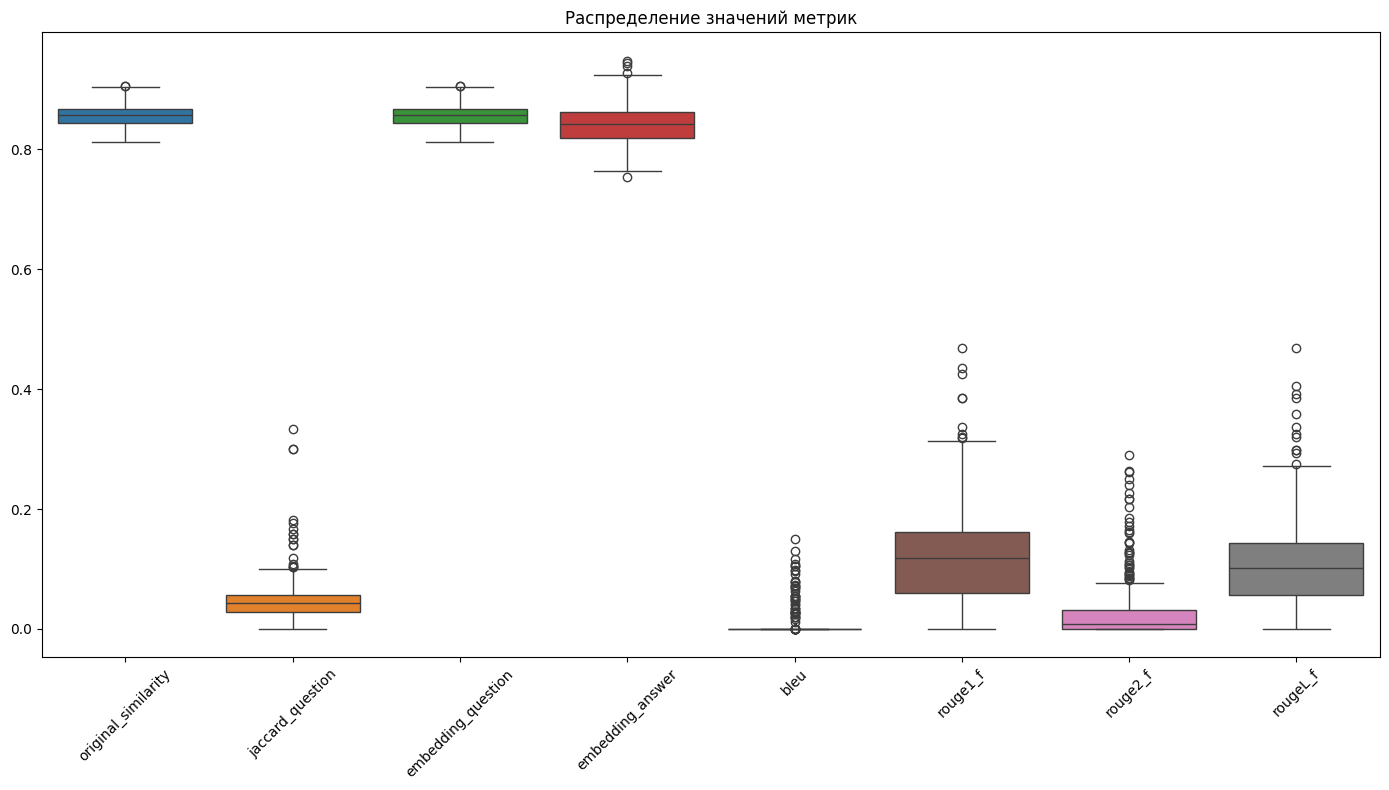

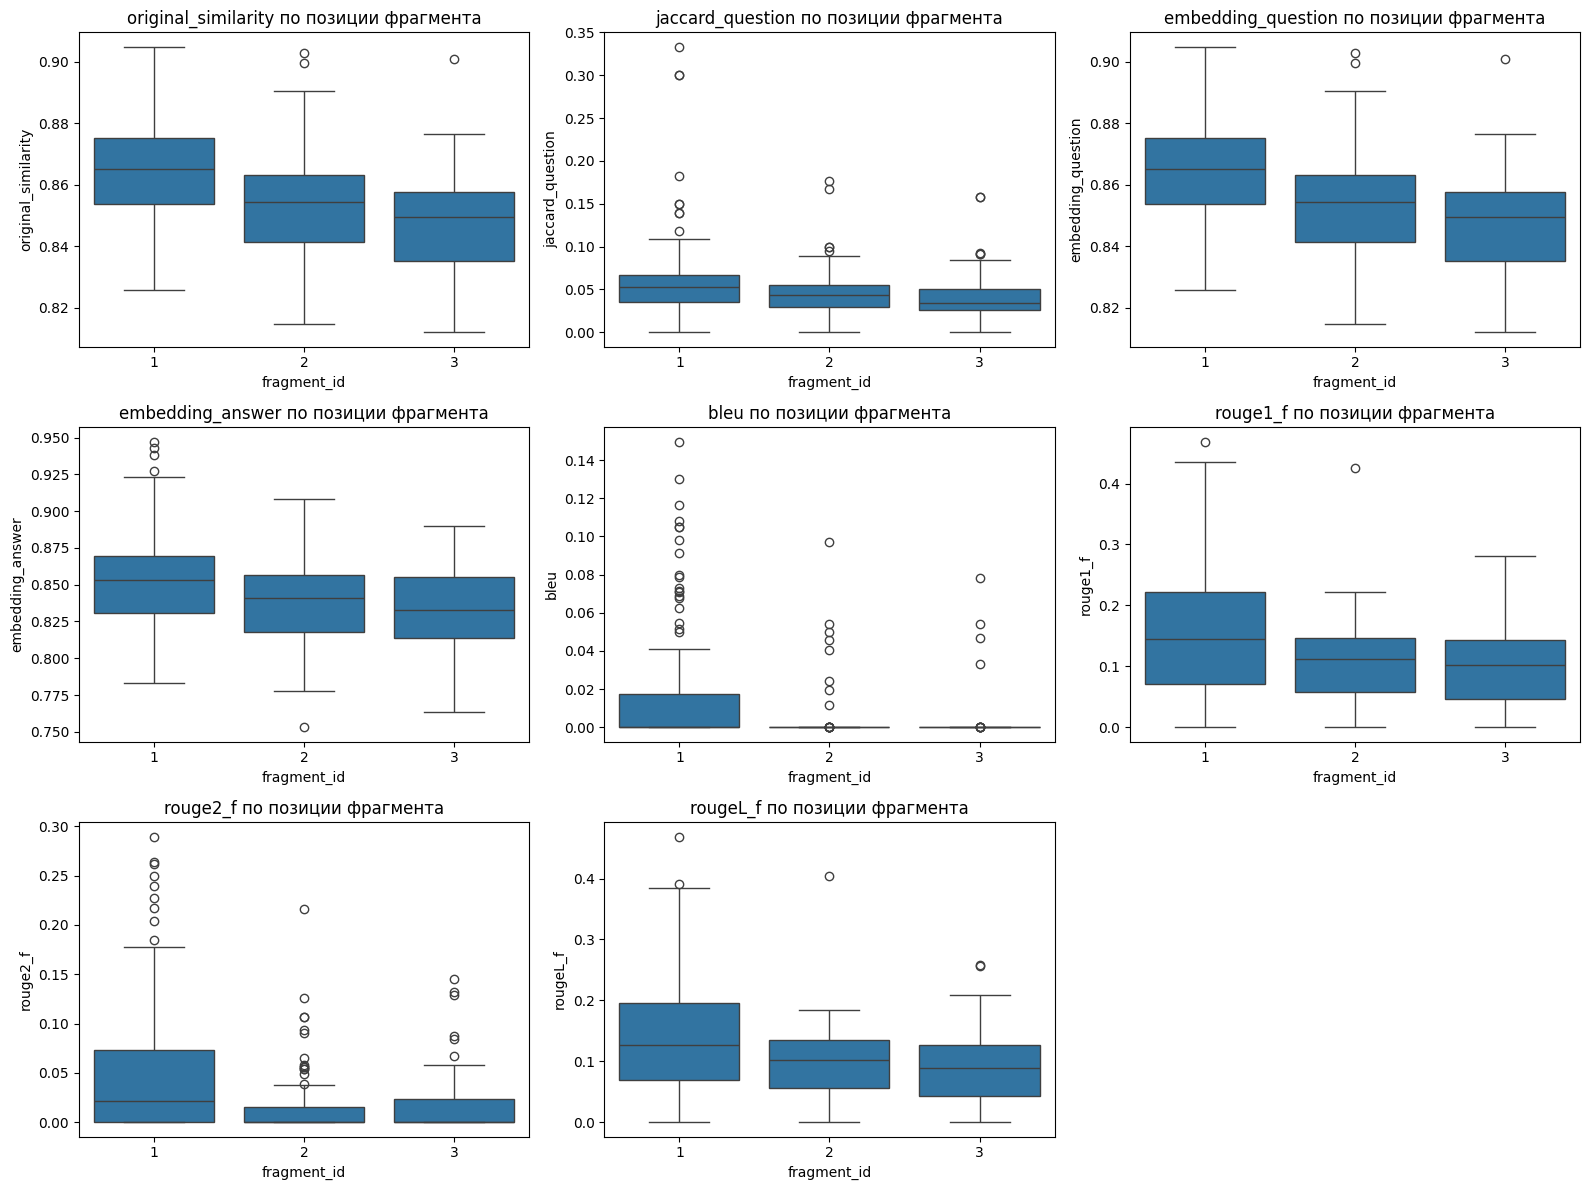

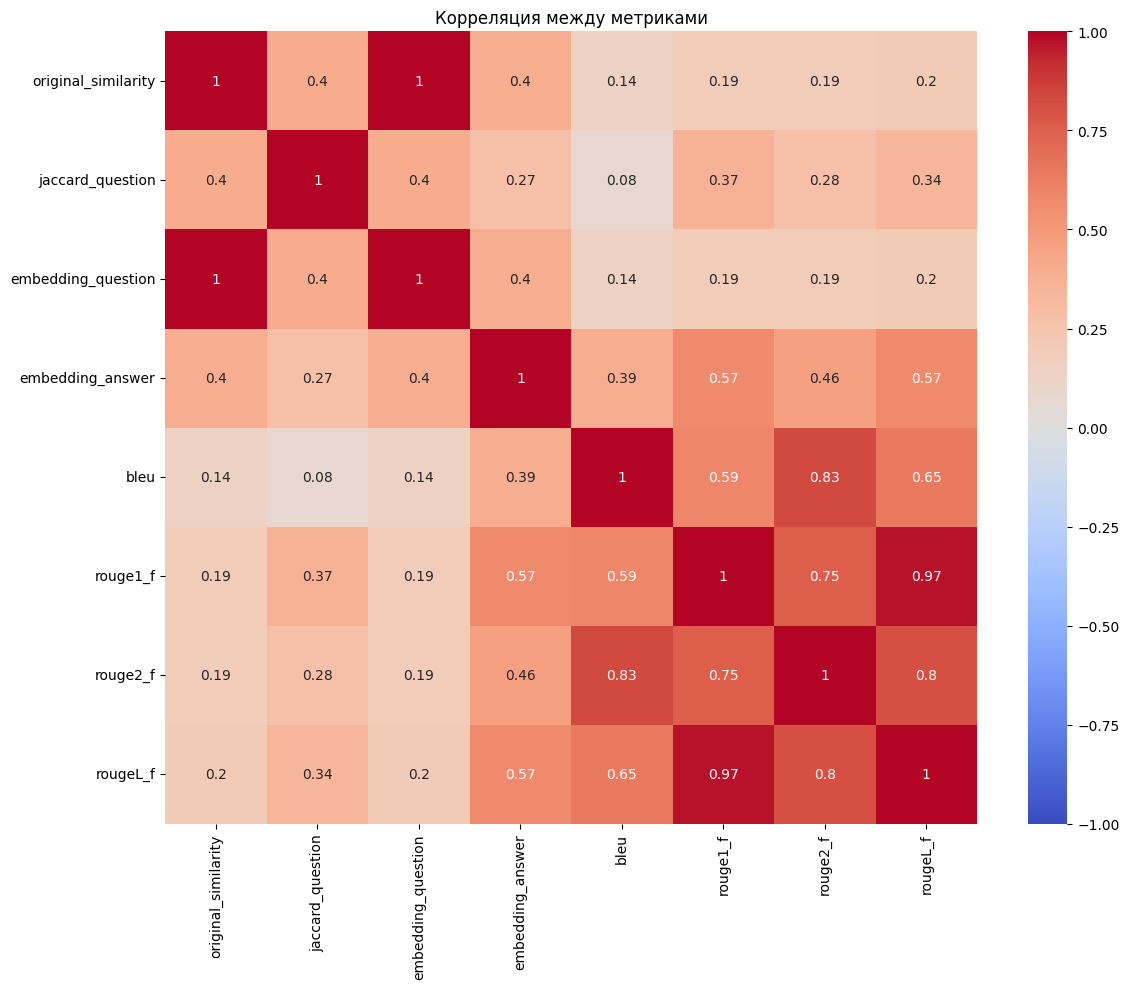


Топ-5 вопросов с наиболее релевантными фрагментами (по embedding_answer):
             embedding_question  embedding_answer  rouge1_f
question_id                                                
10                     0.852009          0.898938  0.214349
110                    0.862242          0.896647  0.180899
103                    0.883614          0.893912  0.246116
66                     0.893587          0.887354  0.103664
11                     0.841409          0.884920  0.155042

Худшие 5 вопросов с наименее релевантными фрагментами (по embedding_answer):
             embedding_question  embedding_answer  rouge1_f
question_id                                                
60                     0.858407          0.777011  0.018864
62                     0.858151          0.782731  0.074420
30                     0.827709          0.785340  0.036304
40                     0.827709          0.785340  0.036304
59                     0.833271          0.798352  0.086266

Доля ф

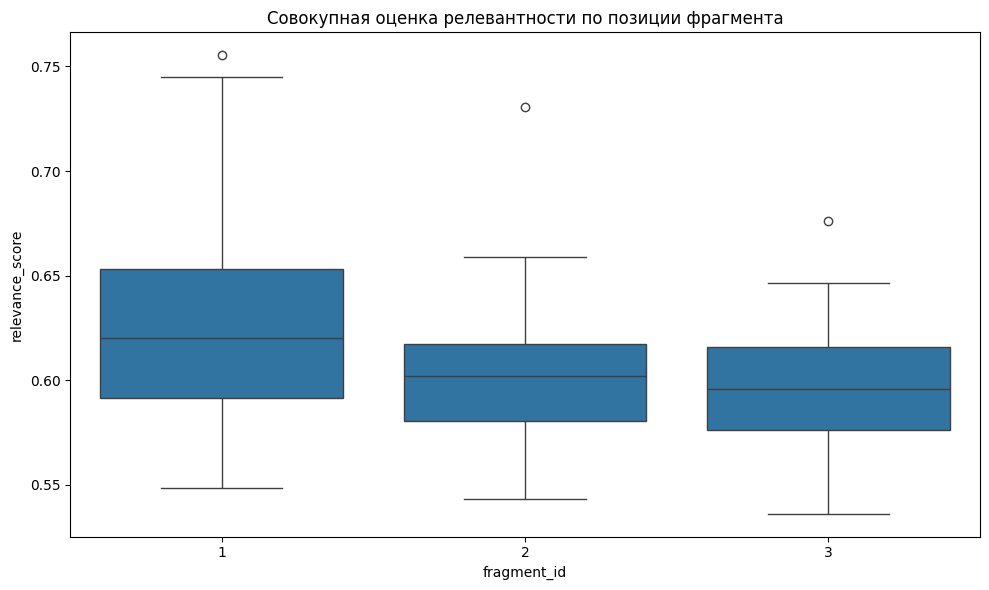

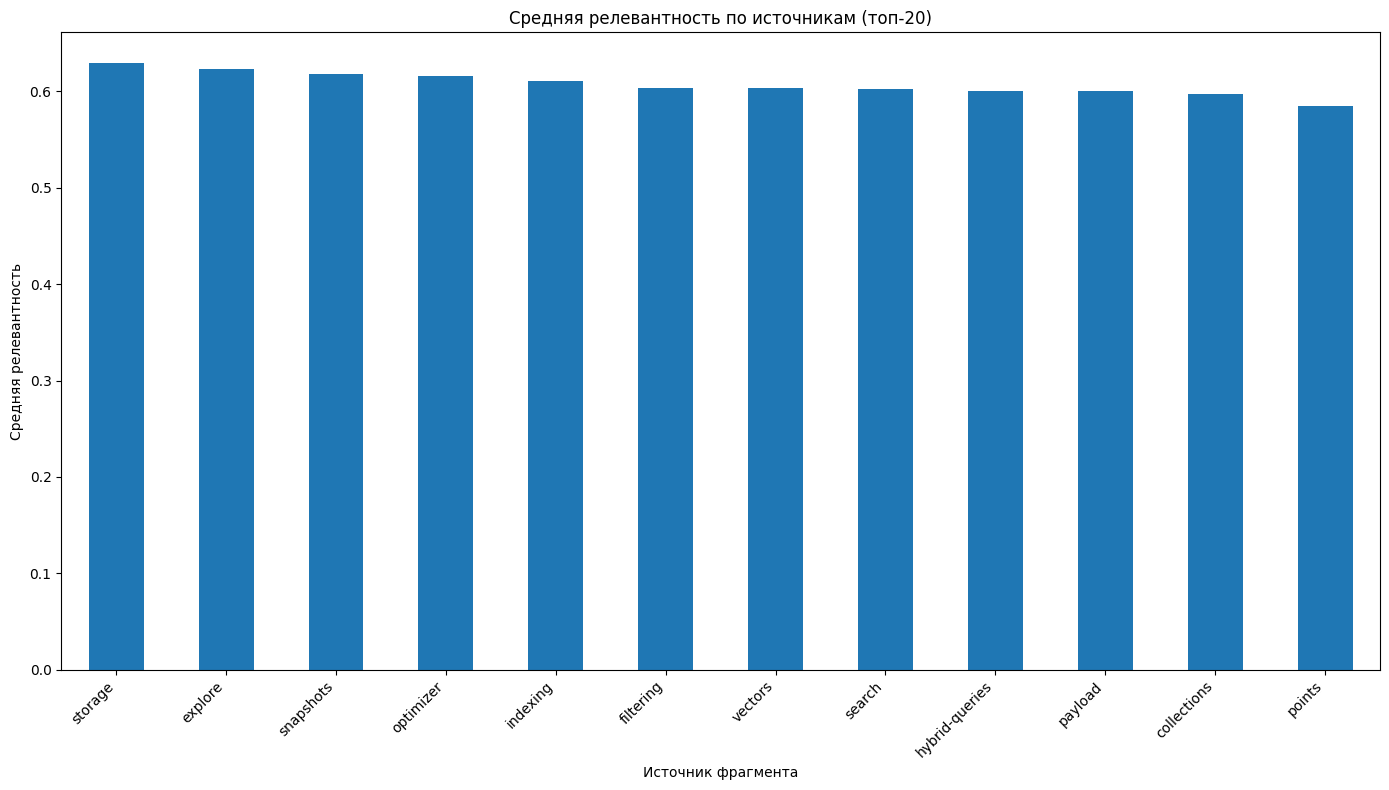

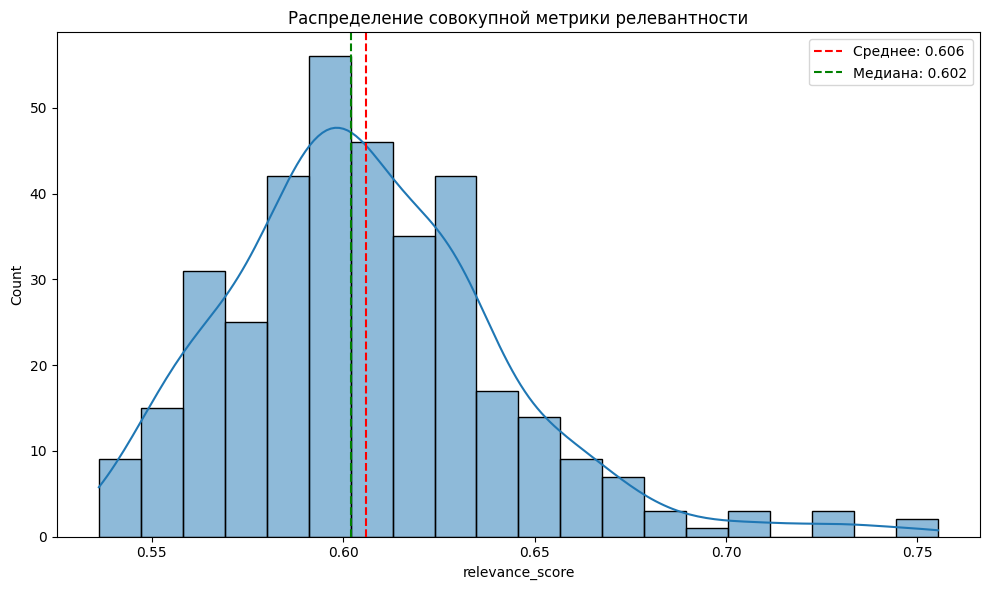

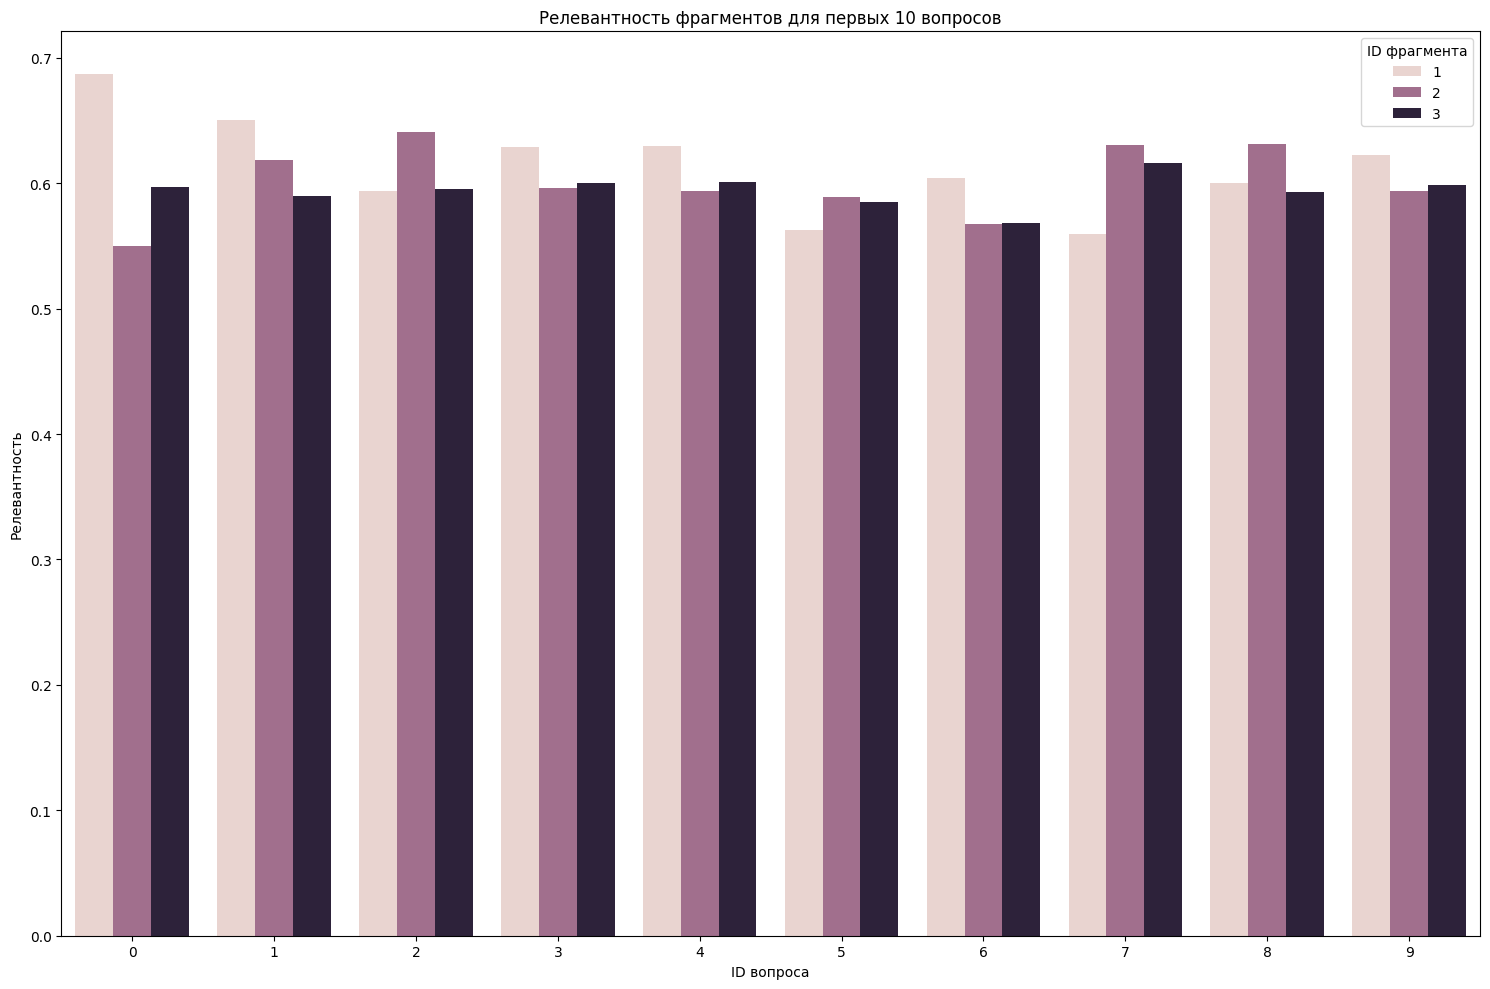

<Figure size 1600x1400 with 0 Axes>

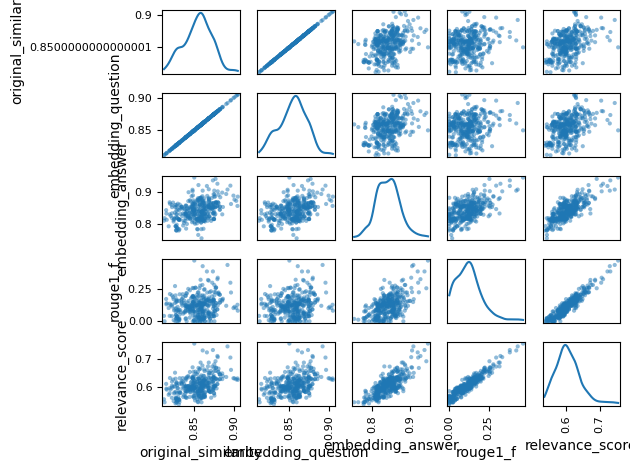

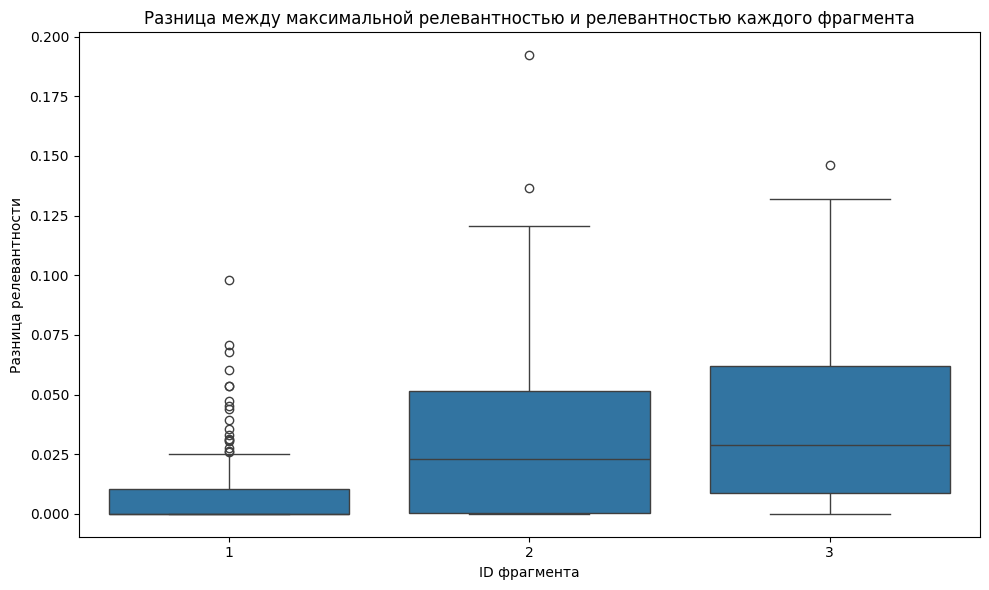

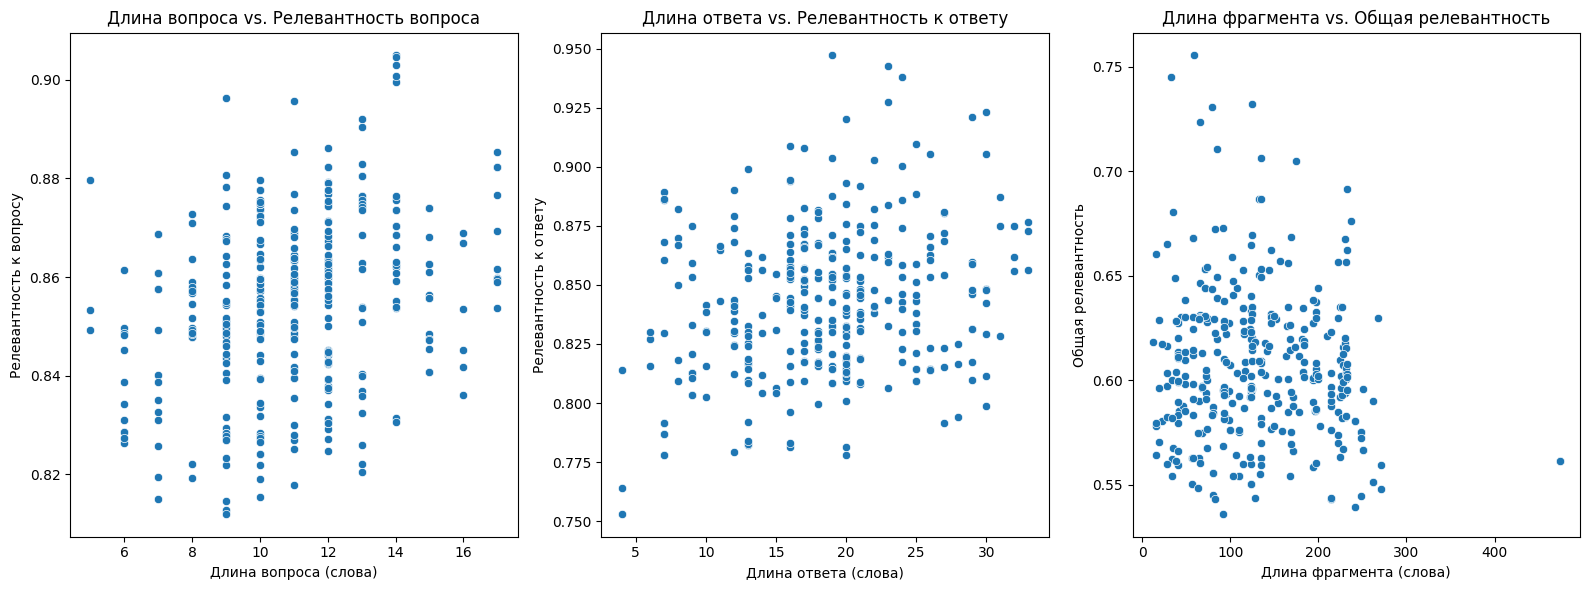

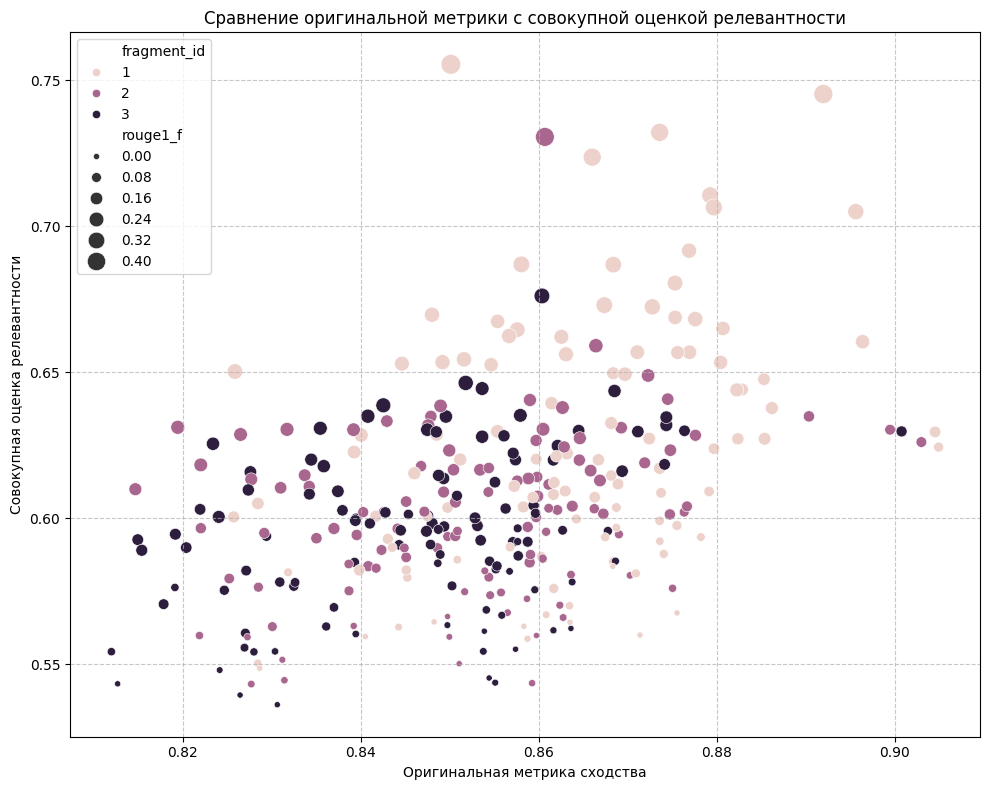

Анализ метрик завершен.
Создана интерактивная тепловая карта: relevance_heatmap.html
Анализ завершен. Все результаты и визуализации сохранены.


In [10]:
# Статистический анализ метрик
def analyze_metrics(results_df):
    """Анализ и визуализация метрик релевантности"""
    
    try:
        # Общая статистика по всем метрикам
        print("Общая статистика по метрикам:")
        metrics_cols = [
            'original_similarity', 'jaccard_question', 'embedding_question', 
            'embedding_answer', 'bleu', 'rouge1_f', 'rouge2_f', 'rougeL_f'
        ]
        print(results_df[metrics_cols].describe())
        
        # Распределение метрик - боксплоты
        plt.figure(figsize=(14, 8))
        sns.boxplot(data=results_df[metrics_cols])
        plt.title('Распределение значений метрик')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # Распределение метрик по позиции фрагмента
        plt.figure(figsize=(16, 12))
        
        for i, metric in enumerate(metrics_cols, 1):
            plt.subplot(3, 3, i)
            sns.boxplot(x='fragment_id', y=metric, data=results_df)
            plt.title(f'{metric} по позиции фрагмента')
        
        plt.tight_layout()
        plt.show()
        
        # Корреляция между метриками
        plt.figure(figsize=(12, 10))
        correlation = results_df[metrics_cols].corr()
        sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title('Корреляция между метриками')
        plt.tight_layout()
        plt.show()
        
        # Анализ по вопросам - средние значения метрик для каждого вопроса
        question_metrics = results_df.groupby('question_id')[metrics_cols].mean()
        
        # Топ-5 и худшие 5 вопросов по embedding_answer
        print("\nТоп-5 вопросов с наиболее релевантными фрагментами (по embedding_answer):")
        top_questions = question_metrics.sort_values('embedding_answer', ascending=False).head(5)
        print(top_questions[['embedding_question', 'embedding_answer', 'rouge1_f']])
        
        print("\nХудшие 5 вопросов с наименее релевантными фрагментами (по embedding_answer):")
        worst_questions = question_metrics.sort_values('embedding_answer', ascending=True).head(5)
        print(worst_questions[['embedding_question', 'embedding_answer', 'rouge1_f']])
        
        # Определение порогов для хорошей релевантности
        thresholds = {
            'original_similarity': 0.7,
            'embedding_question': 0.6,
            'embedding_answer': 0.5,
            'rouge1_f': 0.3
        }
        
        # Доля фрагментов, превышающих пороги
        print("\nДоля фрагментов, превышающих пороги релевантности:")
        for metric, threshold in thresholds.items():
            percentage = (results_df[metric] >= threshold).mean() * 100
            print(f"{metric}: {percentage:.2f}% фрагментов >= {threshold}")
        
        # Создаем совокупную метрику релевантности как среднее нескольких метрик
        results_df['relevance_score'] = results_df[
            ['embedding_question', 'embedding_answer', 'rouge1_f']
        ].mean(axis=1)
        
        # Распределение совокупной метрики по позиции фрагмента
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='fragment_id', y='relevance_score', data=results_df)
        plt.title('Совокупная оценка релевантности по позиции фрагмента')
        plt.tight_layout()
        plt.show()
        
        # Попытаемся создать распределение по источникам, если есть column 'fragment_source'
        if 'fragment_source' in results_df.columns:
            # Ограничим количество источников для визуализации (если их очень много)
            top_sources = results_df['fragment_source'].value_counts().head(20).index
            source_data = results_df[results_df['fragment_source'].isin(top_sources)]
            
            plt.figure(figsize=(14, 8))
            source_relevance = source_data.groupby('fragment_source')['relevance_score'].mean().sort_values(ascending=False)
            source_relevance.plot(kind='bar')
            plt.title('Средняя релевантность по источникам (топ-20)')
            plt.ylabel('Средняя релевантность')
            plt.xlabel('Источник фрагмента')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
        
        # Гистограмма распределения совокупной метрики релевантности
        plt.figure(figsize=(10, 6))
        sns.histplot(results_df['relevance_score'], bins=20, kde=True)
        plt.title('Распределение совокупной метрики релевантности')
        plt.axvline(results_df['relevance_score'].mean(), color='r', linestyle='--', 
                    label=f'Среднее: {results_df["relevance_score"].mean():.3f}')
        plt.axvline(results_df['relevance_score'].median(), color='g', linestyle='--', 
                    label=f'Медиана: {results_df["relevance_score"].median():.3f}')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        # Визуализация для отдельных вопросов - пример для первых 10 вопросов
        # Ограничим до 10 или до количества имеющихся вопросов
        max_questions = min(10, results_df['question_id'].nunique())
        
        plt.figure(figsize=(15, 10))
        question_df = results_df[results_df['question_id'] < max_questions].copy()
        question_df['question_id'] = question_df['question_id'].astype(str)
        sns.barplot(x='question_id', y='relevance_score', hue='fragment_id', data=question_df)
        plt.title(f'Релевантность фрагментов для первых {max_questions} вопросов')
        plt.xlabel('ID вопроса')
        plt.ylabel('Релевантность')
        plt.legend(title='ID фрагмента')
        plt.tight_layout()
        plt.show()
        
        # Матрица скаттерплотов для основных метрик
        main_metrics = ['original_similarity', 'embedding_question', 'embedding_answer', 'rouge1_f', 'relevance_score']
        
        # Используем sample, если данных слишком много
        sample_size = min(1000, len(results_df))
        sample_df = results_df.sample(sample_size)
        
        plt.figure(figsize=(16, 14))
        pd.plotting.scatter_matrix(sample_df[main_metrics], alpha=0.5, diagonal='kde')
        plt.tight_layout()
        plt.show()
        
        # Вычисление и визуализация разницы между релевантностью фрагментов для одного вопроса
        results_df['max_relevance'] = results_df.groupby('question_id')['relevance_score'].transform('max')
        results_df['relevance_diff'] = results_df['max_relevance'] - results_df['relevance_score']
        
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='fragment_id', y='relevance_diff', data=results_df)
        plt.title('Разница между максимальной релевантностью и релевантностью каждого фрагмента')
        plt.xlabel('ID фрагмента')
        plt.ylabel('Разница релевантности')
        plt.tight_layout()
        plt.show()
        
        # Анализ корреляции между длиной вопроса/ответа и релевантностью
        results_df['question_length'] = results_df['question'].apply(lambda x: len(str(x).split()))
        results_df['answer_length'] = results_df['answer'].apply(lambda x: len(str(x).split()))
        results_df['fragment_length'] = results_df['fragment_text'].apply(lambda x: len(str(x).split()))
        
        plt.figure(figsize=(16, 6))
        
        plt.subplot(1, 3, 1)
        sns.scatterplot(x='question_length', y='embedding_question', data=results_df)
        plt.title('Длина вопроса vs. Релевантность вопроса')
        plt.xlabel('Длина вопроса (слова)')
        plt.ylabel('Релевантность к вопросу')
        
        plt.subplot(1, 3, 2)
        sns.scatterplot(x='answer_length', y='embedding_answer', data=results_df)
        plt.title('Длина ответа vs. Релевантность к ответу')
        plt.xlabel('Длина ответа (слова)')
        plt.ylabel('Релевантность к ответу')
        
        plt.subplot(1, 3, 3)
        sns.scatterplot(x='fragment_length', y='relevance_score', data=results_df)
        plt.title('Длина фрагмента vs. Общая релевантность')
        plt.xlabel('Длина фрагмента (слова)')
        plt.ylabel('Общая релевантность')
        
        plt.tight_layout()
        plt.show()
        
        # Добавим сравнение нашей оригинальной метрики с рассчитанными
        plt.figure(figsize=(10, 8))
        sns.scatterplot(
            x='original_similarity', 
            y='relevance_score', 
            hue='fragment_id', 
            size='rouge1_f',
            sizes=(20, 200),
            data=results_df
        )
        plt.title('Сравнение оригинальной метрики с совокупной оценкой релевантности')
        plt.xlabel('Оригинальная метрика сходства')
        plt.ylabel('Совокупная оценка релевантности')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
        # Пытаемся создать интерактивную визуализацию, если доступен plotly
        try:
            import plotly.express as px
            import plotly.io as pio
            from IPython.display import display, HTML
            
            # Выберем 10 лучших и 10 худших вопросов по средней релевантности
            question_avg_relevance = results_df.groupby('question_id')['relevance_score'].mean()
            top10_questions = question_avg_relevance.nlargest(10).index.tolist()
            bottom10_questions = question_avg_relevance.nsmallest(10).index.tolist()
            
            # Отфильтруем данные только для этих вопросов
            highlight_df = results_df[results_df['question_id'].isin(top10_questions + bottom10_questions)]
            
            # Добавим метку для типа вопроса (лучший/худший)
            highlight_df['question_type'] = highlight_df['question_id'].apply(
                lambda x: 'Лучший' if x in top10_questions else 'Худший'
            )
            
            # Создадим тепловую карту
            fig = px.density_heatmap(
                highlight_df, 
                x='question_id', 
                y='fragment_id',
                z='relevance_score',
                color_continuous_scale='Viridis',
                title='Тепловая карта релевантности для лучших и худших вопросов',
                labels={'question_id': 'ID вопроса', 'fragment_id': 'ID фрагмента', 'relevance_score': 'Релевантность'}
            )
            
            # Отображаем интерактивную визуализацию
            display(HTML(fig.to_html()))
            
        except (ImportError, ModuleNotFoundError):
            print("Для интерактивных визуализаций установите библиотеку plotly: pip install plotly")
        except Exception as e:
            print(f"Не удалось создать интерактивную визуализацию: {str(e)}")
        
        print("Анализ метрик завершен.")
        
        return results_df
        
    except Exception as e:
        print(f"Ошибка при анализе метрик: {str(e)}")
        # Попытка минимального анализа при ошибке
        try:
            print("Базовая статистика по метрикам:")
            basic_metrics = ['original_similarity', 'embedding_question', 'embedding_answer']
            print(results_df[basic_metrics].describe())
        except:
            print("Не удалось выполнить даже базовый анализ.")
        
        return results_df

# Добавим вызов функции анализа после создания DataFrame с результатами
results_df = analyze_metrics(results_df)

# Добавим дополнительную визуализацию для сравнения нашей оригинальной метрики с рассчитанными
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='original_similarity', 
    y='relevance_score', 
    hue='fragment_id', 
    size='rouge1_f',
    sizes=(20, 200),
    data=results_df
)
plt.title('Сравнение оригинальной метрики с совокупной оценкой релевантности')
plt.xlabel('Оригинальная метрика сходства')
plt.ylabel('Совокупная оценка релевантности')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('original_vs_calculated_relevance.png')
plt.close()

# Создадим интерактивную тепловую карту для наиболее и наименее релевантных вопросов
try:
    import plotly.express as px
    import plotly.io as pio
    
    # Выберем 10 лучших и 10 худших вопросов по средней релевантности
    question_avg_relevance = results_df.groupby('question_id')['relevance_score'].mean()
    top10_questions = question_avg_relevance.nlargest(10).index.tolist()
    bottom10_questions = question_avg_relevance.nsmallest(10).index.tolist()
    
    # Отфильтруем данные только для этих вопросов
    highlight_df = results_df[results_df['question_id'].isin(top10_questions + bottom10_questions)]
    
    # Добавим метку для типа вопроса (лучший/худший)
    highlight_df['question_type'] = highlight_df['question_id'].apply(
        lambda x: 'Лучший' if x in top10_questions else 'Худший'
    )
    
    # Создадим тепловую карту
    fig = px.density_heatmap(
        highlight_df, 
        x='question_id', 
        y='fragment_id',
        z='relevance_score',
        color_continuous_scale='Viridis',
        title='Тепловая карта релевантности для лучших и худших вопросов',
        labels={'question_id': 'ID вопроса', 'fragment_id': 'ID фрагмента', 'relevance_score': 'Релевантность'}
    )
    
    # Сохраняем интерактивную визуализацию
    pio.write_html(fig, 'relevance_heatmap.html')
    print("Создана интерактивная тепловая карта: relevance_heatmap.html")
except ImportError:
    print("Для создания интерактивных визуализаций установите библиотеку plotly: pip install plotly")

# Анализ корреляции между длиной вопроса/ответа и релевантностью
results_df['question_length'] = results_df['question'].apply(lambda x: len(x.split()))
results_df['answer_length'] = results_df['answer'].apply(lambda x: len(x.split()))
results_df['fragment_length'] = results_df['fragment_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(16, 6))

plt.subplot(1, 3, 1)
sns.scatterplot(x='question_length', y='embedding_question', data=results_df)
plt.title('Длина вопроса vs. Релевантность вопроса')
plt.xlabel('Длина вопроса (слова)')
plt.ylabel('Релевантность к вопросу')

plt.subplot(1, 3, 2)
sns.scatterplot(x='answer_length', y='embedding_answer', data=results_df)
plt.title('Длина ответа vs. Релевантность к ответу')
plt.xlabel('Длина ответа (слова)')
plt.ylabel('Релевантность к ответу')

plt.subplot(1, 3, 3)
sns.scatterplot(x='fragment_length', y='relevance_score', data=results_df)
plt.title('Длина фрагмента vs. Общая релевантность')
plt.xlabel('Длина фрагмента (слова)')
plt.ylabel('Общая релевантность')

plt.tight_layout()
plt.savefig('length_vs_relevance.png')
plt.close()

print("Анализ завершен. Все результаты и визуализации сохранены.")